In [1]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from ICSS import *

warnings.filterwarnings('ignore')

In [2]:
def load_data(file_path: str, sat_no: str, start_date: str, end_date: str, created_time: bool):
    '''
    :param file_path: 위성데이터가 있는 폴더경로
    :param sat_no: 위성번호
    :param start_date: 불러올 데이터의 시작날짜
    :param end_date: 불러올 데이터의 종료날짜
    :param created_time: created time인지 epoch time인지 여부
    :return: 시간 단위로 추출된 통계량 DataFrame
    '''
    if created_time:
        info_df = pd.read_csv(f'{file_path}/{sat_no}_created.csv')
    if not created_time:
        info_df = pd.read_csv(f'{file_path}/{sat_no}_epoch.csv')
    info_df = info_df.set_index('Time').sort_index()
    info_df.index = pd.to_datetime(info_df.index)
    info_df = info_df[info_df.index > start_date].copy()
    info_df = info_df[info_df.index <= end_date].copy()
    hour_df = info_df[::60].copy()
    hour_df['Semi-Major Axis(km)'] = (hour_df['Perigee'] + hour_df['Apogee']) / 2
    hour_df['Semi-Major Axis(km)'] = hour_df['Semi-Major Axis(km)'] / 100
    return hour_df

In [3]:
created_hour_df = load_data('../../Database', '42984', '2022-12-31 23:59:59', '2024-08-01 00:00:00', True)
epoch_hour_df = load_data('../../Database', '42984', '2022-12-31 23:59:59', '2024-08-01 00:00:00', False)

In [4]:
hour_df = epoch_hour_df

ol_all_infos = []
col_lst = ['Eccentricity', 'Semi-Major Axis(km)']
for col in col_lst:
    diff_value = np.log(hour_df[col]).diff().fillna(0).values
    for level in [95, 99]:
        for window in [24 * 5, 24 * 10]:
            temp = [col, level, window, 'ON']
            print(f'window : {window}, level : {level}')
            temp.extend(ol_detect_2024_KT(hour_df, diff_value, window, level, 'ON'))
            ol_all_infos.append(temp)

temp_df = pd.DataFrame(ol_all_infos).astype('str')

window : 120, level : 95


100%|██████████| 13753/13753 [00:03<00:00, 3950.46it/s]


window : 240, level : 95


100%|██████████| 13633/13633 [00:03<00:00, 4024.98it/s]


window : 120, level : 99


100%|██████████| 13753/13753 [00:03<00:00, 4047.04it/s]


window : 240, level : 99


100%|██████████| 13633/13633 [00:03<00:00, 4122.37it/s]


window : 120, level : 95


100%|██████████| 13753/13753 [00:03<00:00, 4035.28it/s]


window : 240, level : 95


100%|██████████| 13633/13633 [00:03<00:00, 4038.59it/s]


window : 120, level : 99


100%|██████████| 13753/13753 [00:03<00:00, 3976.73it/s]


window : 240, level : 99


100%|██████████| 13633/13633 [00:03<00:00, 4082.87it/s]


95% threshold, 120hours


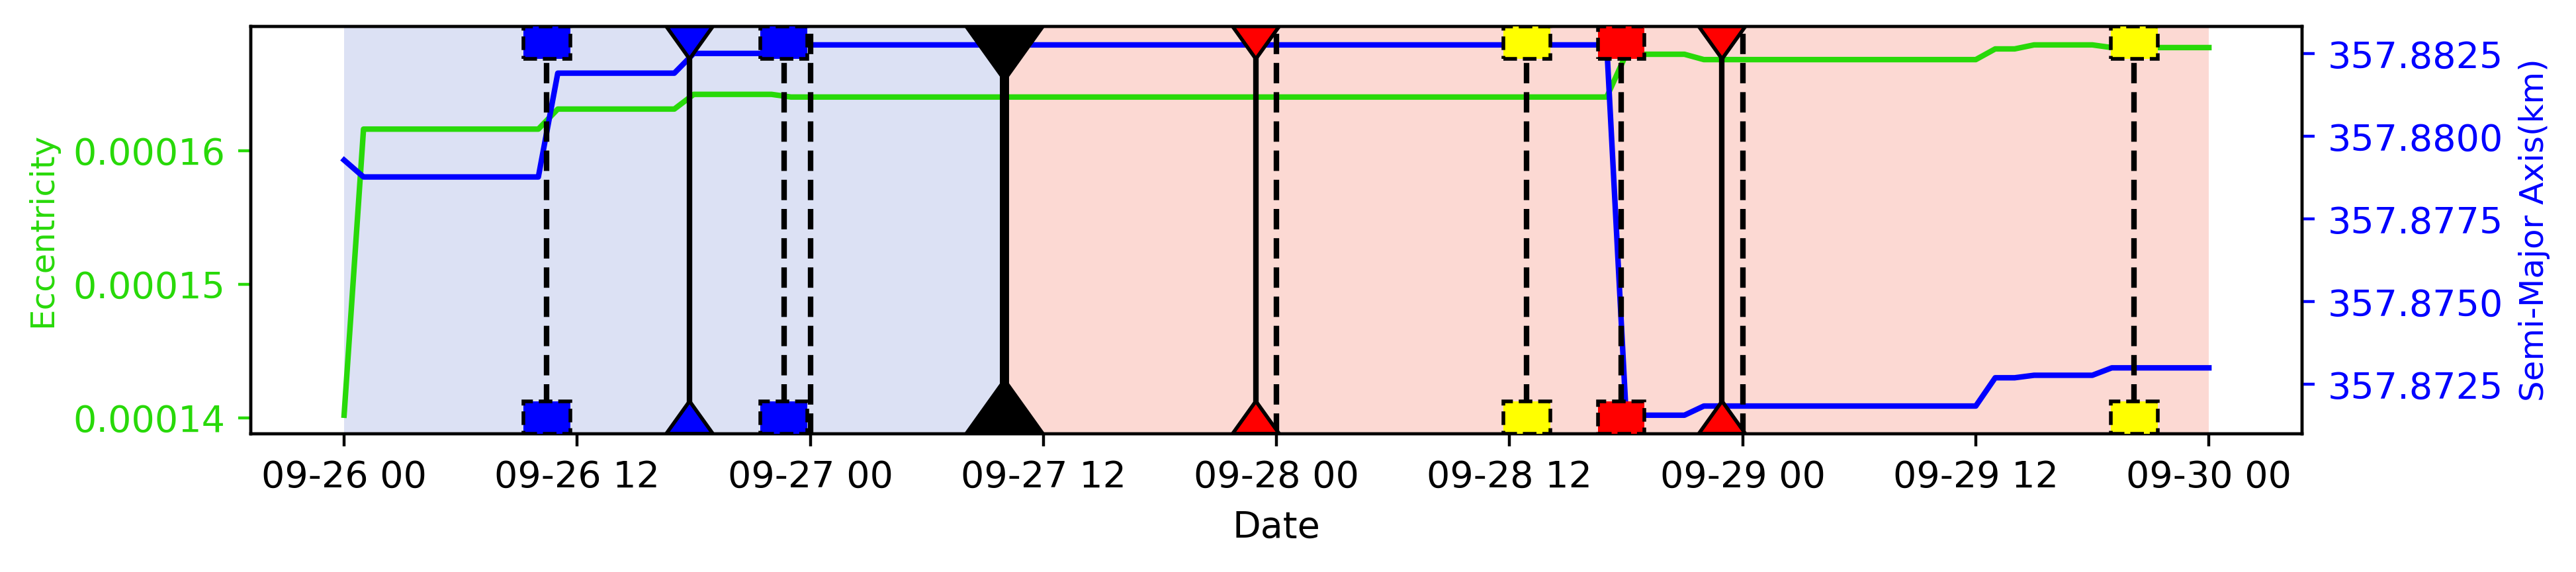

95% threshold, 240hours


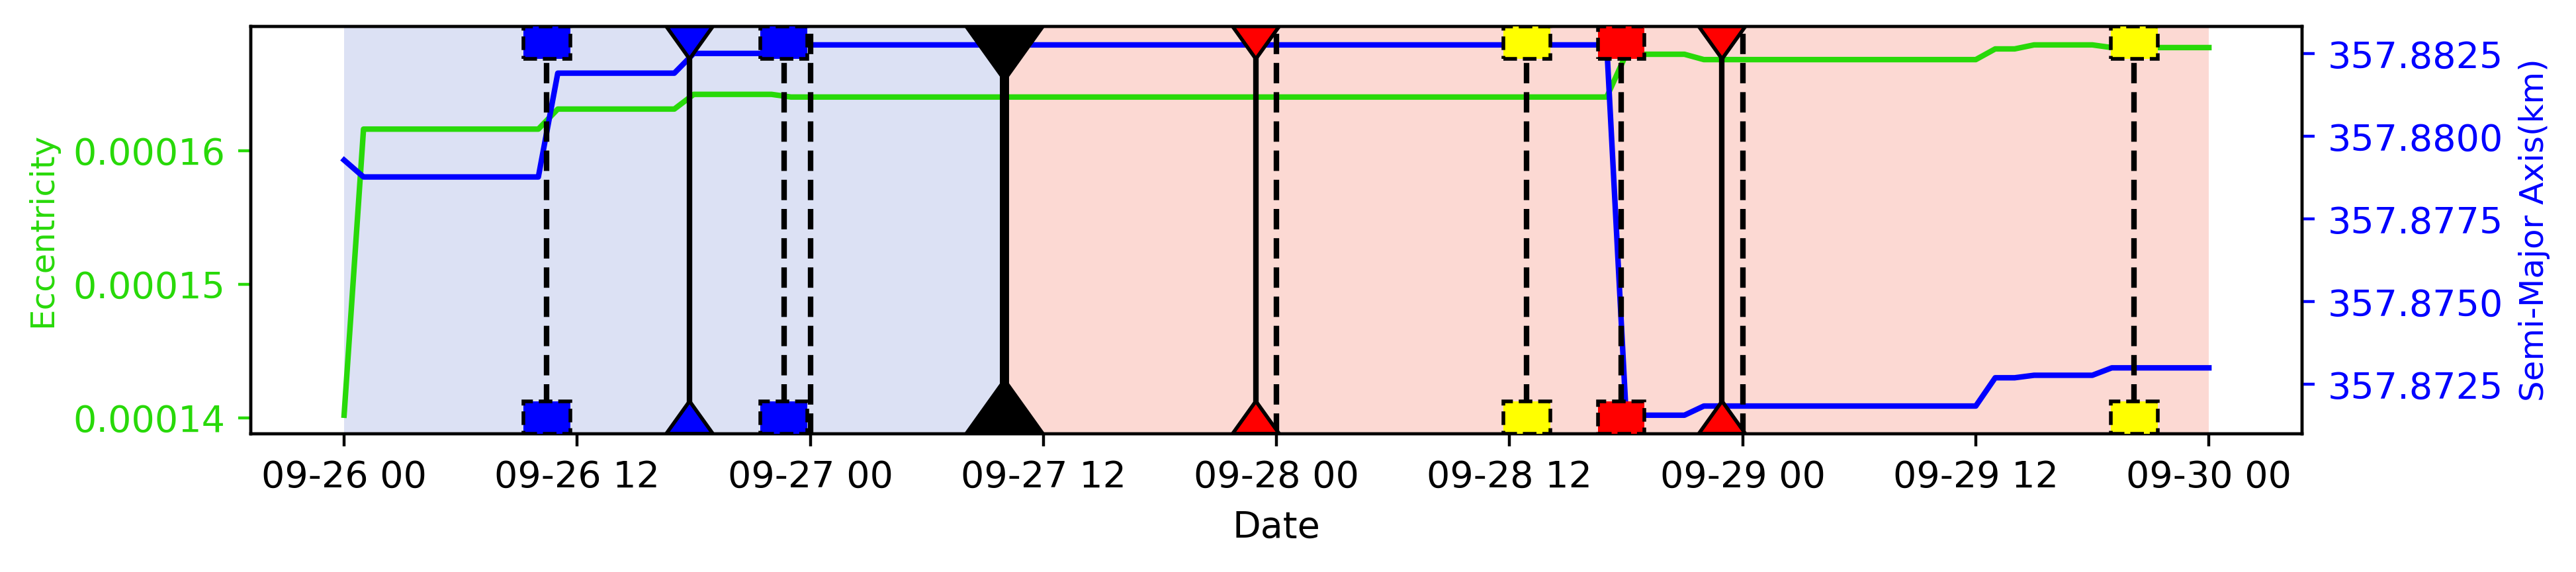

99% threshold, 120hours


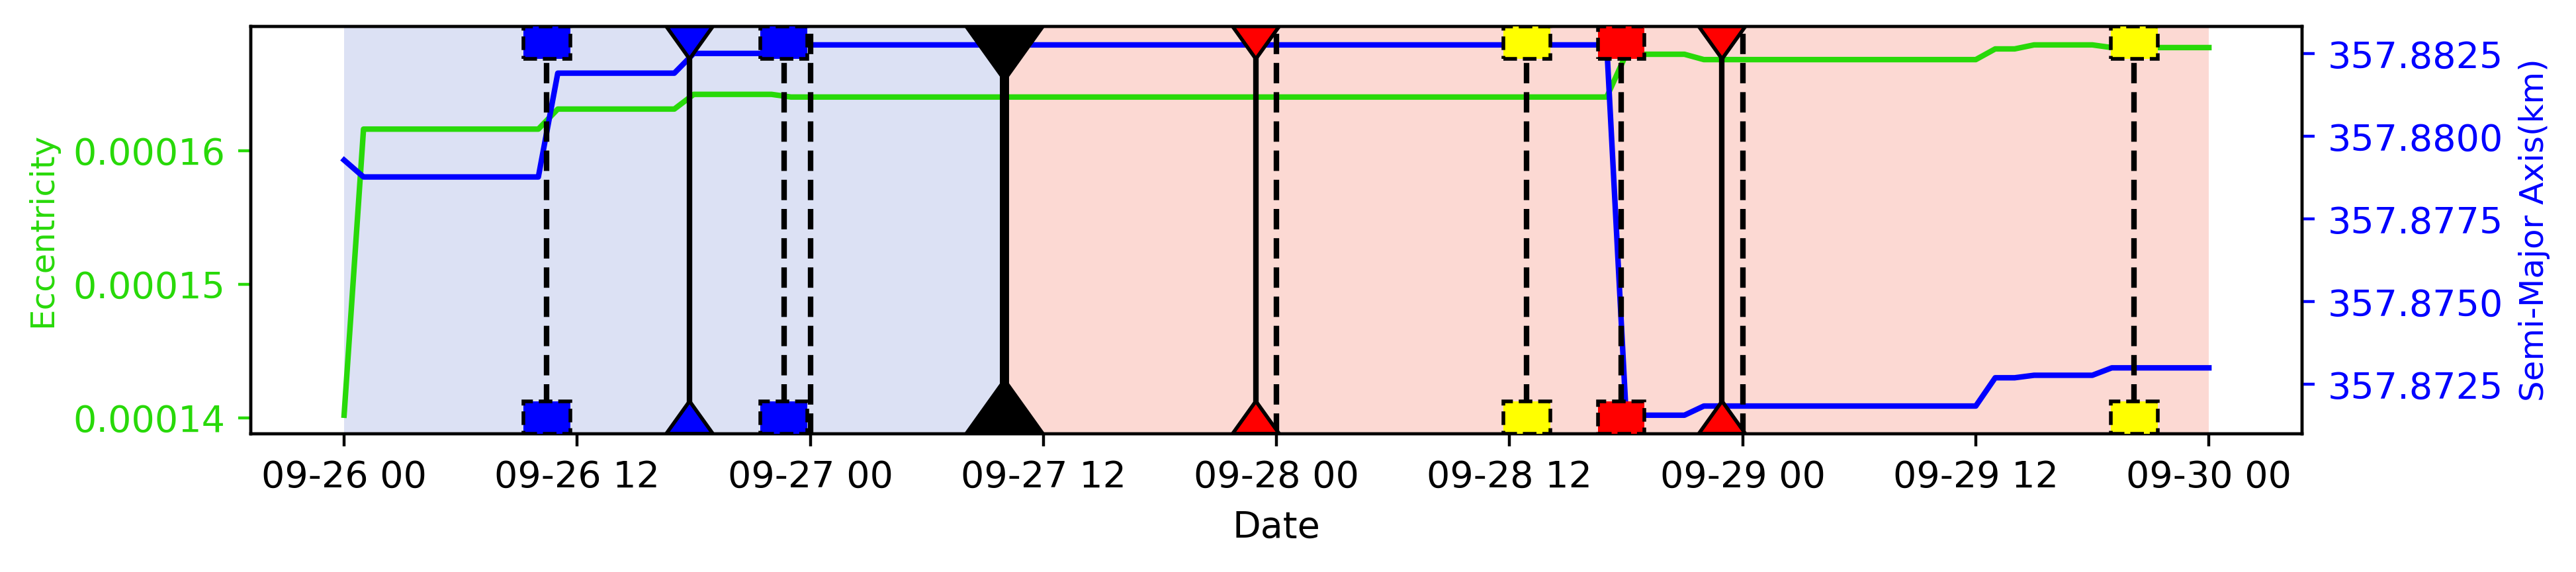

99% threshold, 240hours


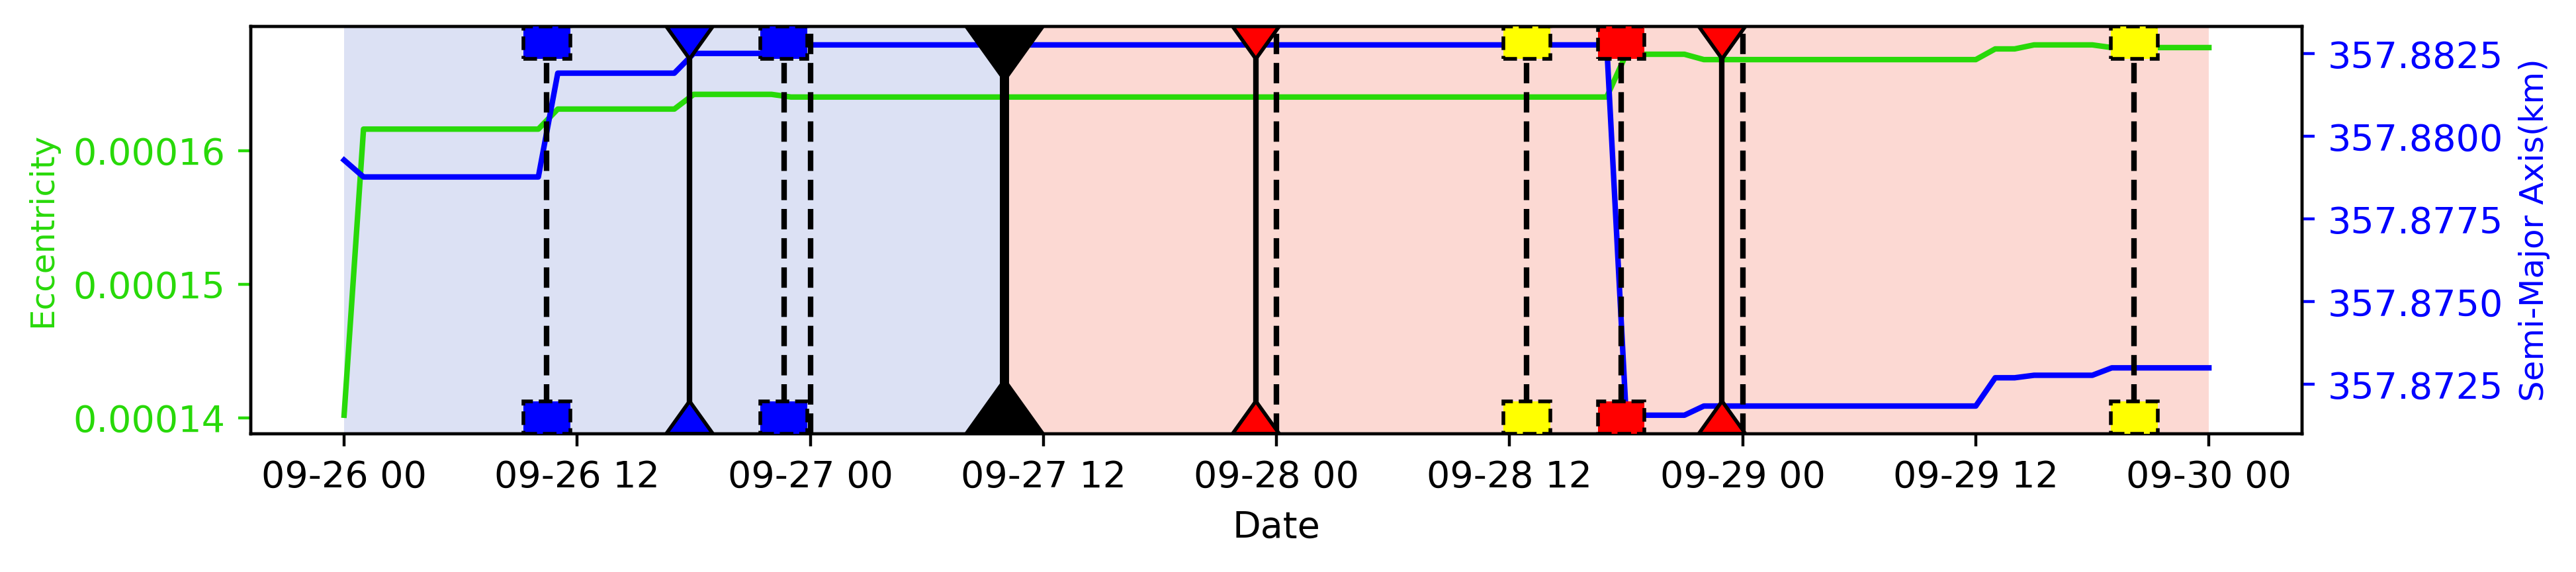

In [5]:
start_date='2023-09-26 00:00:00'
end_date='2023-09-30 00:00:00'

# 이상치탐지 DataFrame으로 그래프 출력
for i in range(4):
    # 두 가지 통계량에서 모두 탐지된 이상치만 True 이상치로 분류
    eccen_lst = temp_df.iloc[i][4:]
    Sma_lst = temp_df.iloc[i + 4][4:]
    co_ol_lst = [pd.to_datetime(ol) for ol in list(set(eccen_lst) & set(Sma_lst)) if ol != 'NaT']
    co_ol_lst.sort()
    print(list(temp_df.iloc[i][1:4])[0] + '% threshold, ' + list(temp_df.iloc[i][1:4])[1] + 'hours')


    # 첫번째 통계량의 그래프를 출력
    fig, ax1 = plt.subplots(figsize=(10, 2), dpi=400)
    ax1.plot(hour_df[temp_df.iloc[i][0]][(pd.to_datetime(start_date) <= hour_df[temp_df.iloc[i][0]].index) & (
            hour_df[temp_df.iloc[i][0]].index <= pd.to_datetime(end_date))],
             color=(40 / 255, 217 / 255, 9 / 255), label=temp_df.iloc[i][0])
    ax1.set_xlabel('Date')
    ax1.set_ylabel(temp_df.iloc[i][0], fontsize=9, color=(40 / 255, 217 / 255, 9 / 255))
    ax1.tick_params(axis='y', colors=(40 / 255, 217 / 255, 9 / 255))

    # 배경 색칠하는 부분
    plt.axvspan(xmin=pd.to_datetime('2023-09-26'), xmax=pd.to_datetime('2023-09-27 10:00:00'), facecolor='#DCE1F4')
    plt.axvspan(xmin=pd.to_datetime('2023-09-27 10:00:00'), xmax=pd.to_datetime('2023-9-30'), facecolor='#FCD9D3')

    # 두번째 통계량의 그래프를 출력
    ax2 = ax1.twinx()
    ax2.plot(
        hour_df[temp_df.iloc[i + 4][0]][(pd.to_datetime(start_date) <= hour_df[temp_df.iloc[i + 4][0]].index) & (
                hour_df[temp_df.iloc[i + 4][0]].index <= pd.to_datetime(end_date))], color=(0, 0, 1),
        label=temp_df.iloc[i + 4][0])
    ax2.set_ylabel(temp_df.iloc[i + 4][0], fontsize=9, color=(0, 0, 1))
    ax2.tick_params(axis='y', colors=(0, 0, 1))
    formatter = ticker.ScalarFormatter(useOffset=False)
    ax2.yaxis.set_major_formatter(formatter)
    
    # KT maneuvering 표시
    kt_data = [pd.to_datetime('2023-09-27 10:00:00')]
    for time in kt_data:
        if (pd.to_datetime('2023-09-26 00:00:00') <= time) & (time <= pd.to_datetime('2023-09-30 00:00:00')):
            ax2.axvline(time, color='black', linewidth=2.5, linestyle='-')

            start_time = time - pd.Timedelta(days=0.075)
            end_time = time + pd.Timedelta(days=0.075)

            triangle1 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[0]),
                                         (mdates.date2num(time),
                                          ax2.get_ylim()[0] + (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.12),
                                         (mdates.date2num(end_time), ax2.get_ylim()[0])),
                                        facecolor='black', edgecolor='black', linewidth=2.5, linestyle='-', zorder=10)
            ax2.add_patch(triangle1)

            triangle2 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[1]),
                                         (mdates.date2num(time),
                                          ax2.get_ylim()[1] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.12),
                                         (mdates.date2num(end_time), ax2.get_ylim()[1])),
                                        facecolor='black', edgecolor='black', linewidth=2.5, linestyle='-', zorder=10)
            ax2.add_patch(triangle2)

    for point in [pd.to_datetime('2023-09-26 17:47:05'), pd.to_datetime('2023-09-27 22:56:17'),
                  pd.to_datetime('2023-09-28 22:56:17')]:

        # 기준 시점별 maneuvering 색 다르게 함.
        if (pd.to_datetime('2023-09-24') <= point) & (point <= pd.to_datetime('2023-09-30 00:00:00')):
            if (pd.to_datetime('2023-09-27 10:00:00') <= point):
                if (pd.to_datetime('2023-09-28') <= point):
                    start_time = point - pd.Timedelta(days=0.05)
                    end_time = point + pd.Timedelta(days=0.05)
                    ax2.axvline(point, color='black', linewidth=1.5, linestyle='-')
                    triangle1 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[0]),
                                                 (mdates.date2num(point),
                                                  ax2.get_ylim()[0] + (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                                                 (mdates.date2num(end_time), ax2.get_ylim()[0])),
                                                facecolor='red', edgecolor='black', linewidth=1, linestyle='-',
                                                zorder=10)
                    ax2.add_patch(triangle1)

                    triangle2 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[1]),
                                                 (mdates.date2num(point),
                                                  ax2.get_ylim()[1] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                                                 (mdates.date2num(end_time), ax2.get_ylim()[1])),
                                                facecolor='red', edgecolor='black', linewidth=1, linestyle='-',
                                                zorder=10)
                    ax2.add_patch(triangle2)
                    
                else:
                    start_time = point - pd.Timedelta(days=0.05)
                    end_time = point + pd.Timedelta(days=0.05)
                    ax2.axvline(point, color='black', linewidth=1.5)
                    triangle1 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[0]),
                                                 (mdates.date2num(point),
                                                  ax2.get_ylim()[0] + (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                                                 (mdates.date2num(end_time), ax2.get_ylim()[0])),
                                                facecolor='red', edgecolor='black', linewidth=1, linestyle='-',
                                                zorder=10)
                    ax2.add_patch(triangle1)

                    triangle2 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[1]),
                                                 (mdates.date2num(point),
                                                  ax2.get_ylim()[1] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                                                 (mdates.date2num(end_time), ax2.get_ylim()[1])),
                                                facecolor='red', edgecolor='black', linewidth=1, linestyle='-',
                                                zorder=10)
                    ax2.add_patch(triangle2)
                    
            else:
                start_time = point - pd.Timedelta(days=0.05)
                end_time = point + pd.Timedelta(days=0.05)
                ax2.axvline(point, color='black', linewidth=1.5, linestyle='-')
                triangle1 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[0]),
                                             (mdates.date2num(point),
                                              ax2.get_ylim()[0] + (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                                             (mdates.date2num(end_time), ax2.get_ylim()[0])),
                                            facecolor=(0, 0, 1), edgecolor='black', linewidth=1, linestyle='-',
                                            zorder=10)
                ax2.add_patch(triangle1)

                triangle2 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[1]),
                                             (mdates.date2num(point),
                                              ax2.get_ylim()[1] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                                             (mdates.date2num(end_time), ax2.get_ylim()[1])),
                                            facecolor=(0, 0, 1), edgecolor='black', linewidth=1, linestyle='-',
                                            zorder=10)
                ax2.add_patch(triangle2)

    for point in [pd.to_datetime('2023-09-26 10:26:16'), pd.to_datetime('2023-09-26 22:38:31'),
                  pd.to_datetime('2023-09-28 17:44:42')]:

        if (pd.to_datetime('2023-09-24') <= point) & (point <= pd.to_datetime('2023-09-30 00:00:00')):
            start_time = point - pd.Timedelta(days=0.05)
            end_time = point + pd.Timedelta(days=0.05)
            ax2.axvline(point, color='black', linewidth=1.5, linestyle='--')
            if (pd.to_datetime('2023-09-27 10:00:00') >= point):
                rect1 = patches.Rectangle((mdates.date2num(start_time), ax2.get_ylim()[0]),
                                          mdates.date2num(end_time) - mdates.date2num(start_time),
                                          (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08,
                                          facecolor=(0, 0, 1), edgecolor='black', linewidth=1, linestyle='--',
                                          zorder=10)
                ax2.add_patch(rect1)
                rect2 = patches.Rectangle(
                    (mdates.date2num(start_time), ax2.get_ylim()[1] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                    mdates.date2num(end_time) - mdates.date2num(start_time),
                    (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08,
                    facecolor=(0, 0, 1), edgecolor='black', linewidth=1, linestyle='--', zorder=10)
                ax2.add_patch(rect2)
                
            else:
                rect1 = patches.Rectangle((mdates.date2num(start_time), ax2.get_ylim()[0]),
                                          mdates.date2num(end_time) - mdates.date2num(start_time),
                                          (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08,
                                          facecolor=(1, 0, 0), edgecolor='black', linewidth=1, linestyle='--',
                                          zorder=10)
                ax2.add_patch(rect1)
                rect2 = patches.Rectangle(
                    (mdates.date2num(start_time), ax2.get_ylim()[1] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                    mdates.date2num(end_time) - mdates.date2num(start_time),
                    (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08,
                    facecolor=(1, 0, 0), edgecolor='black', linewidth=1, linestyle='--', zorder=10)
                ax2.add_patch(rect2)

    for point in [pd.to_datetime('2023-09-29 20:09:39')]:
        if (pd.to_datetime('2023-09-24') <= point) & (point <= pd.to_datetime('2023-09-30 00:00:00')):
            start_time = point - pd.Timedelta(days=0.05)
            end_time = point + pd.Timedelta(days=0.05)
            ax2.axvline(point, color='black', linewidth=1.5, linestyle='--')
            rect1 = patches.Rectangle((mdates.date2num(start_time), ax2.get_ylim()[0]),
                                      mdates.date2num(end_time) - mdates.date2num(start_time),
                                      (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08,
                                      facecolor='yellow', edgecolor='black', linewidth=1, linestyle='--', zorder=10)
            ax2.add_patch(rect1)
            rect2 = patches.Rectangle(
                (mdates.date2num(start_time), ax2.get_ylim()[1] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                mdates.date2num(end_time) - mdates.date2num(start_time),
                (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08,
                facecolor='yellow', edgecolor='black', linewidth=1, linestyle='--', zorder=10)
            ax2.add_patch(rect2)

    for point in [pd.to_datetime('2023-09-28 12:53:21')]:
        start_time = point - pd.Timedelta(days=0.05)
        end_time = point + pd.Timedelta(days=0.05)

        ax2.axvline(point, color='black', linewidth=1.5, linestyle='--')
        rect1 = patches.Rectangle((mdates.date2num(start_time), ax2.get_ylim()[0]),
                                  mdates.date2num(end_time) - mdates.date2num(start_time),
                                  (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08,
                                  facecolor='yellow', edgecolor='black', linewidth=1, linestyle='--', zorder=10)
        ax2.add_patch(rect1)

        rect2 = patches.Rectangle(
            (mdates.date2num(start_time), ax2.get_ylim()[1] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
            mdates.date2num(end_time) - mdates.date2num(start_time),
            (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08,
            facecolor='yellow', edgecolor='black', linewidth=1, linestyle='--', zorder=10)
        ax2.add_patch(rect2)

    for point in [pd.to_datetime('2023-09-27 00:00:00'), pd.to_datetime('2023-09-28 00:00:00'),
                  pd.to_datetime('2023-09-29 00:00:00')]:
        if (pd.to_datetime('2023-09-24') <= point) & (point <= pd.to_datetime('2023-09-30 00:00:00')):
            start_time = point - pd.Timedelta(days=0.05)
            end_time = point + pd.Timedelta(days=0.05)
            ax2.axvline(point, color='black', linewidth=1.5, linestyle='--')

    plt.xlabel('Date')
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    by_label = dict(zip(labels, handles))
    plt.show()

95% threshold, 120hours


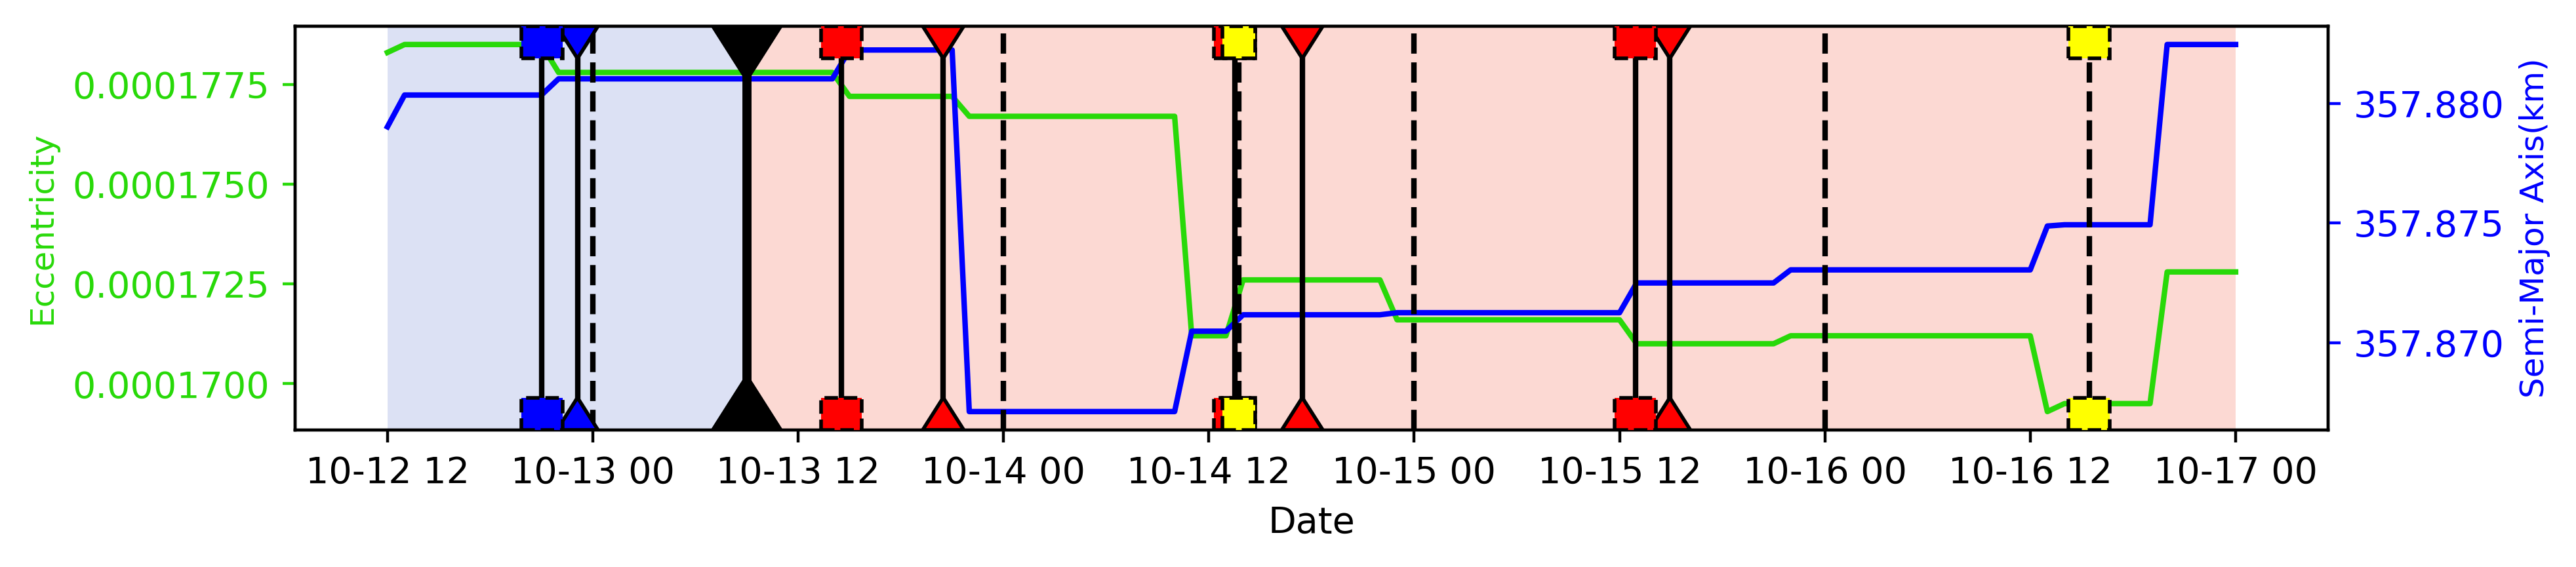

95% threshold, 240hours


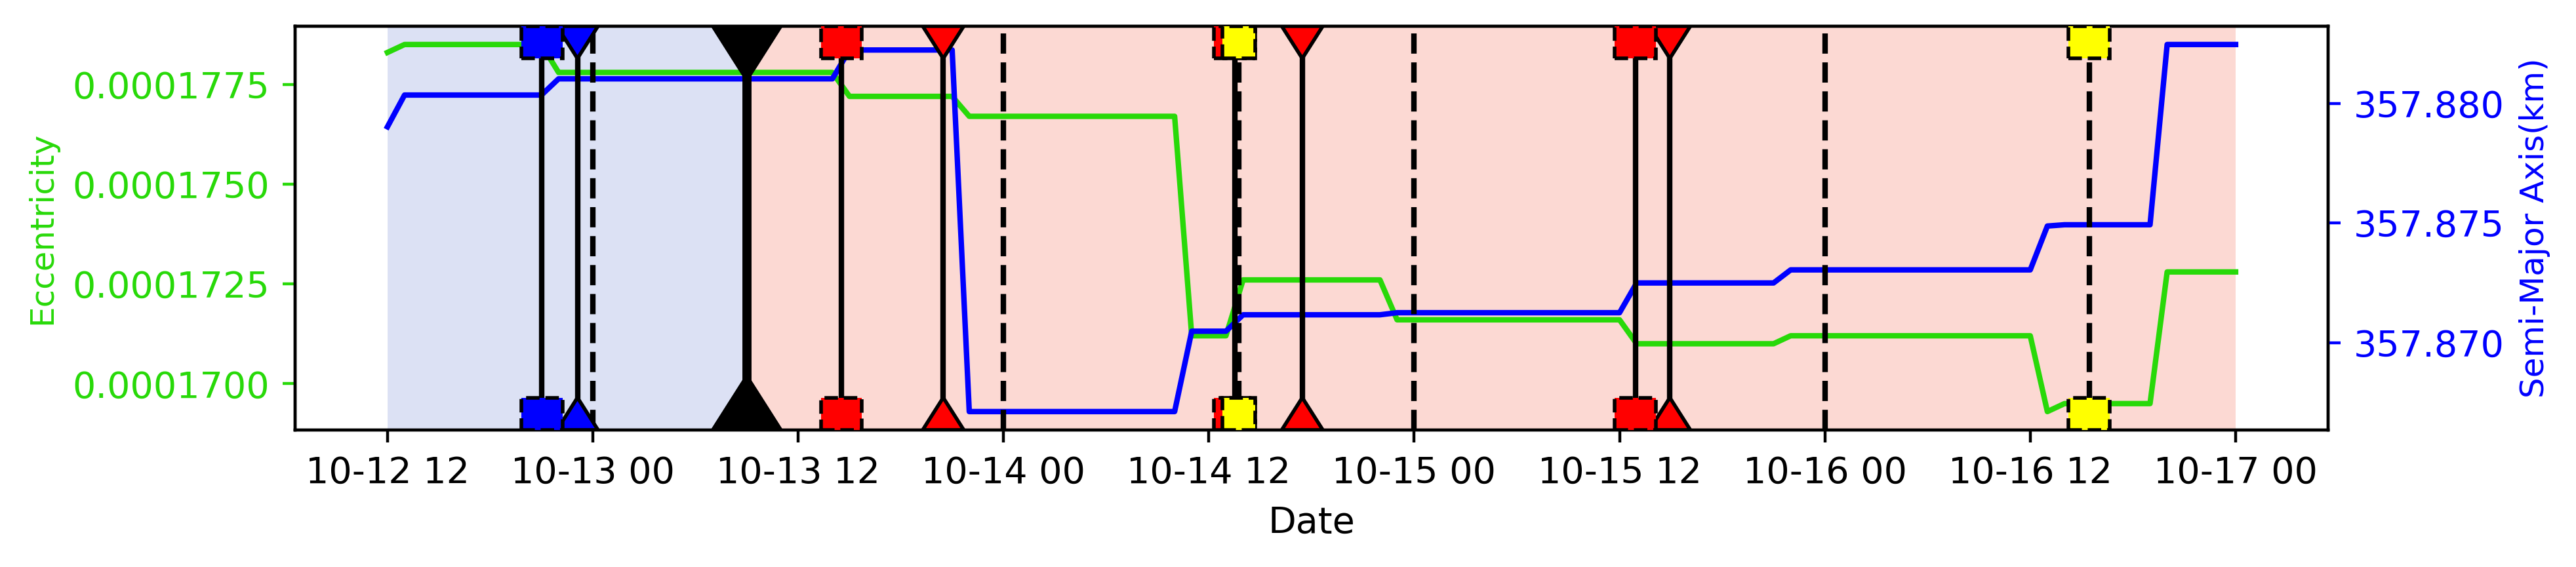

99% threshold, 120hours


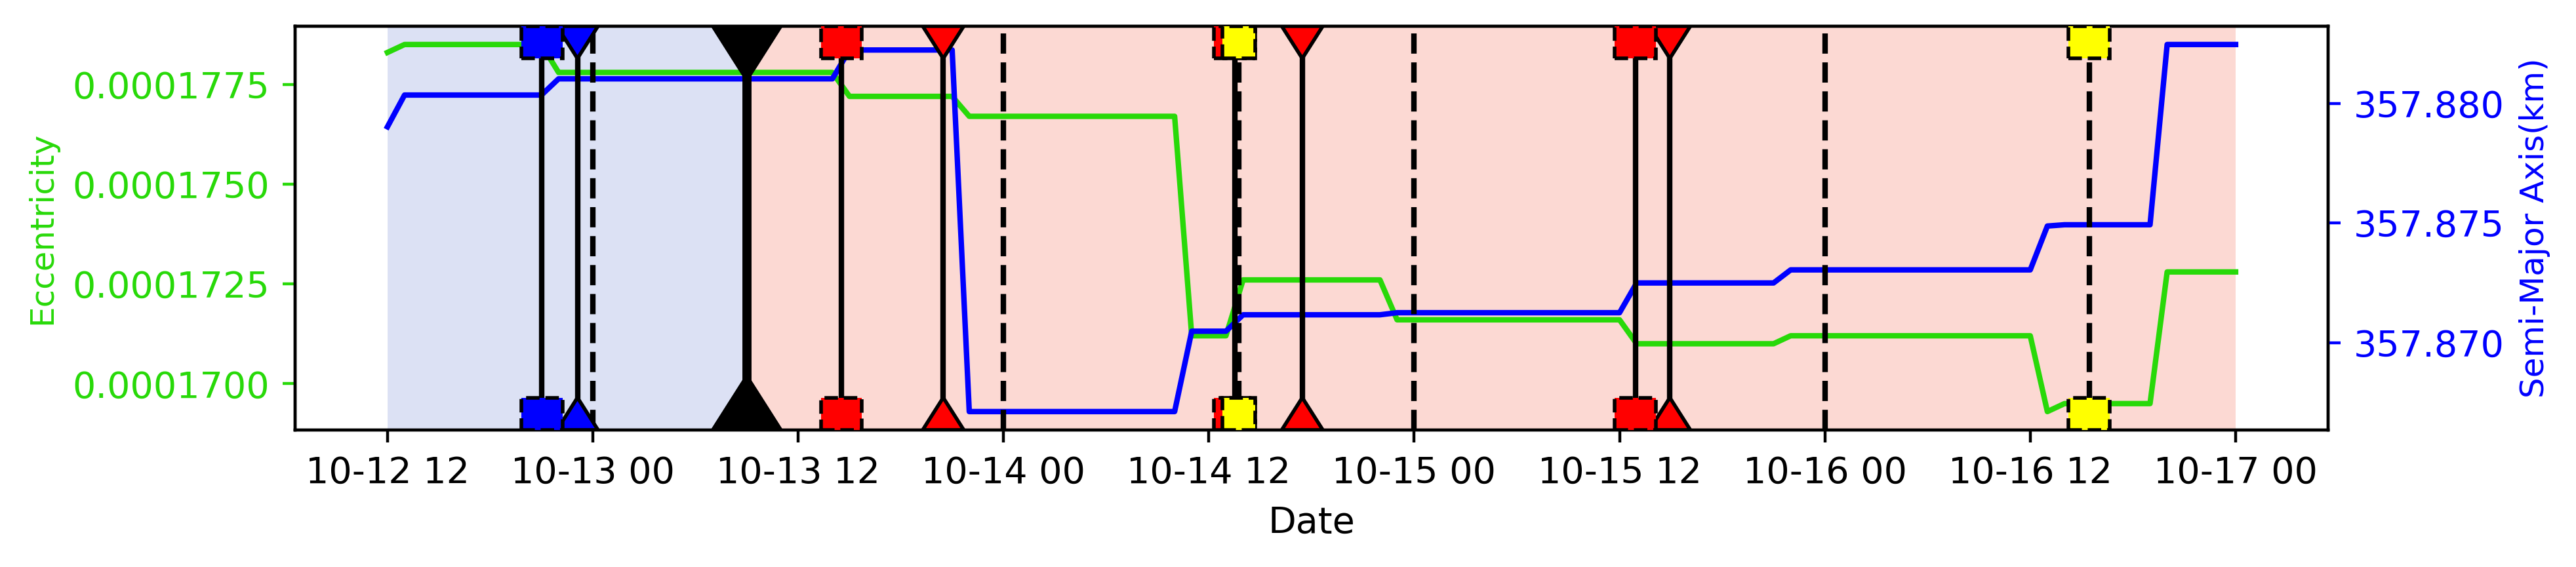

99% threshold, 240hours


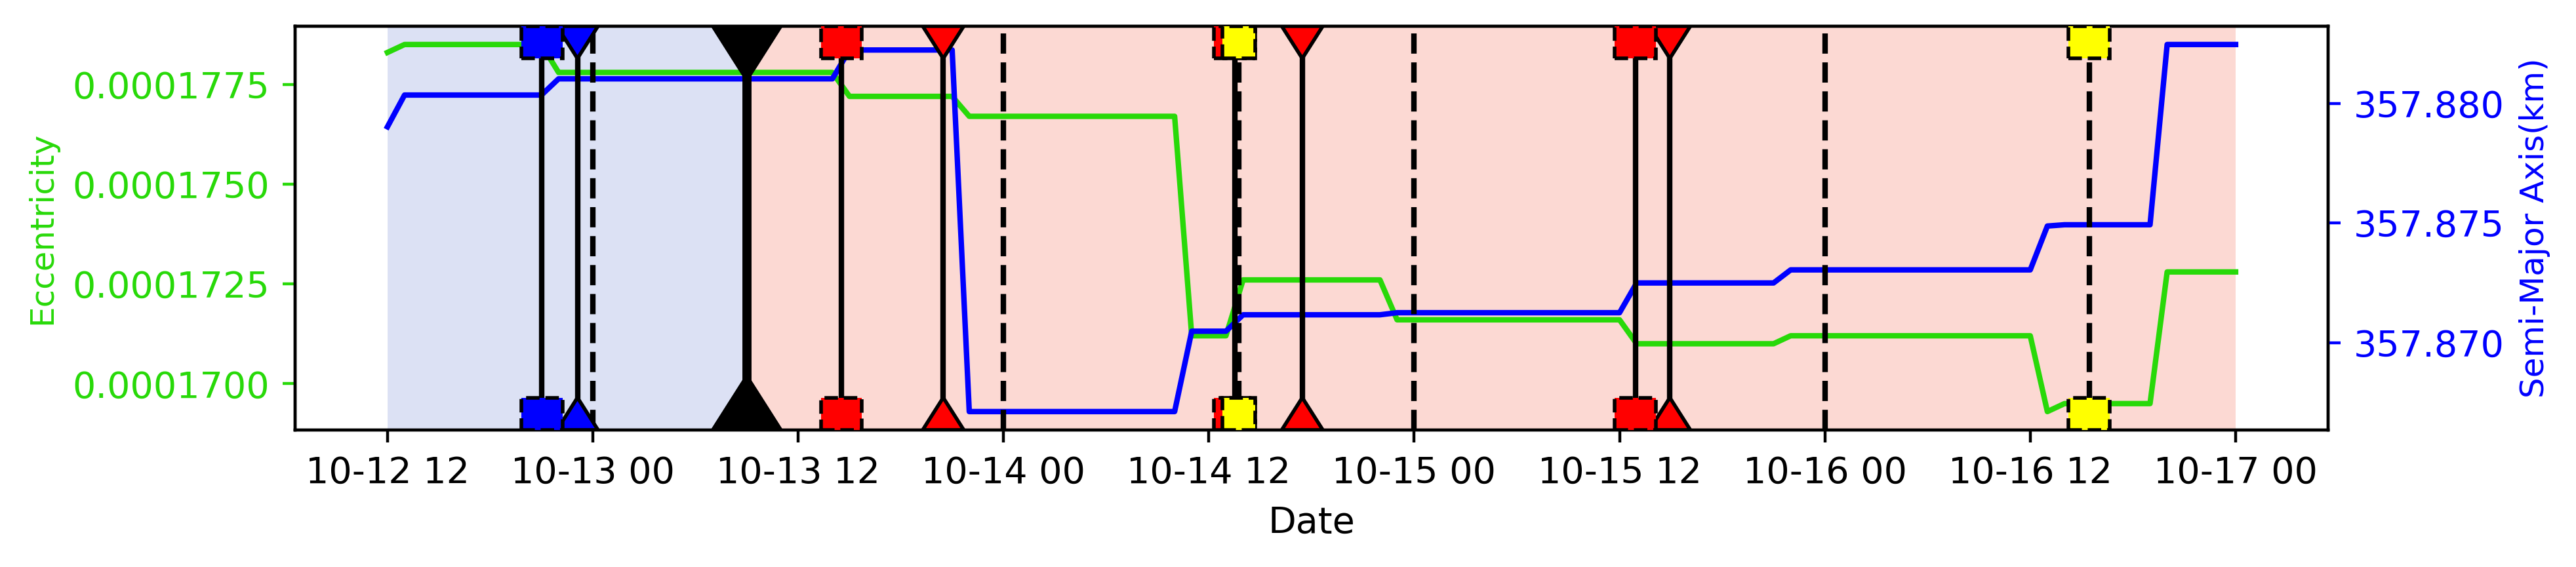

In [6]:
start_date='2023-10-12 12:00:00'
end_date='2023-10-17 00:00:00'

# 이상치탐지 DataFrame으로 그래프 출력
for i in range(4):
    # 두 가지 통계량에서 모두 탐지된 이상치만 True 이상치로 분류
    eccen_lst = temp_df.iloc[i][4:]
    Sma_lst = temp_df.iloc[i + 4][4:]
    co_ol_lst = [pd.to_datetime(ol) for ol in list(set(eccen_lst) & set(Sma_lst)) if ol != 'NaT']
    co_ol_lst.sort()
    print(list(temp_df.iloc[i][1:4])[0] + '% threshold, ' + list(temp_df.iloc[i][1:4])[1] + 'hours')
    
    # 첫번째 통계량의 그래프를 출력
    fig, ax1 = plt.subplots(figsize=(10, 2), dpi=400)
    ax1.plot(hour_df[temp_df.iloc[i][0]][(pd.to_datetime(start_date) <= hour_df[temp_df.iloc[i][0]].index) & (
            hour_df[temp_df.iloc[i][0]].index <= pd.to_datetime(end_date))],
             color=(40 / 255, 217 / 255, 9 / 255), label=temp_df.iloc[i][0])
    ax1.set_xlabel('Date')
    ax1.set_ylabel(temp_df.iloc[i][0], fontsize=9, color=(40 / 255, 217 / 255, 9 / 255))
    ax1.tick_params(axis='y', colors=(40 / 255, 217 / 255, 9 / 255))

    # 배경색칠하는 부분
    plt.axvspan(xmin=pd.to_datetime('2023-10-12 12:00:00'), xmax=pd.to_datetime('2023-10-13 09:00:00'), facecolor='#DCE1F4')
    plt.axvspan(xmin=pd.to_datetime('2023-10-13 09:00:00'), xmax=pd.to_datetime('2023-10-17'), facecolor='#FCD9D3')
    
    # 두번째 통계량의 그래프를 출력
    ax2 = ax1.twinx()
    ax2.plot(
        hour_df[temp_df.iloc[i + 4][0]][(pd.to_datetime(start_date) <= hour_df[temp_df.iloc[i + 4][0]].index) & (
                hour_df[temp_df.iloc[i + 4][0]].index <= pd.to_datetime(end_date))], color=(0, 0, 1),
        label=temp_df.iloc[i + 4][0])
    ax2.set_ylabel(temp_df.iloc[i + 4][0], fontsize=9, color=(0, 0, 1))
    ax2.tick_params(axis='y', colors=(0, 0, 1))
    formatter = ticker.ScalarFormatter(useOffset=False)
    ax2.yaxis.set_major_formatter(formatter)

    # KT maneuvering 표시
    kt_data = [pd.to_datetime('2023-10-13 09:00:00')]
    for time in kt_data:
        if (pd.to_datetime('2023-10-12 12:00:00') <= time) & (time <= pd.to_datetime('2023-10-17 00:00:00')):
            ax2.axvline(time, color='black', linewidth=2.5, linestyle='-')

            start_time = time - pd.Timedelta(days=0.075)
            end_time = time + pd.Timedelta(days=0.075)

            triangle1 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[0]),
                                         (mdates.date2num(time),
                                          ax2.get_ylim()[0] + (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.12),
                                         (mdates.date2num(end_time), ax2.get_ylim()[0])),
                                        facecolor='black', edgecolor='black', linewidth=2.5, linestyle='-', zorder=10)
            ax2.add_patch(triangle1)

            triangle2 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[1]),
                                         (mdates.date2num(time),
                                          ax2.get_ylim()[1] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.12),
                                         (mdates.date2num(end_time), ax2.get_ylim()[1])),
                                        facecolor='black', edgecolor='black', linewidth=2.5, linestyle='-', zorder=10)
            ax2.add_patch(triangle2)

    for point in [pd.to_datetime('2023-10-12 23:06:19'), pd.to_datetime('2023-10-13 20:28:42'),
                  pd.to_datetime('2023-10-14 17:27:37'), pd.to_datetime('2023-10-15 14:56:18')]:

        # 기준 시점별 maneuvering 색 다르게 함.
        if (pd.to_datetime('2023-10-13 09:00:00') <= point):
            start_time = point - pd.Timedelta(days=0.05)
            end_time = point + pd.Timedelta(days=0.05)
            ax2.axvline(point, color='black', linewidth=1.5, linestyle='-')
            triangle1 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[0]),
                                         (mdates.date2num(point),
                                          ax2.get_ylim()[0] + (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                                         (mdates.date2num(end_time), ax2.get_ylim()[0])),
                                        facecolor='red', edgecolor='black', linewidth=1, linestyle='-', zorder=10)
            ax2.add_patch(triangle1)

            triangle2 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[1]),
                                         (mdates.date2num(point),
                                          ax2.get_ylim()[1] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                                         (mdates.date2num(end_time), ax2.get_ylim()[1])),
                                        facecolor='red', edgecolor='black', linewidth=1, linestyle='-', zorder=10)
            ax2.add_patch(triangle2)
            
        else:
            start_time = point - pd.Timedelta(days=0.05)
            end_time = point + pd.Timedelta(days=0.05)
            ax2.axvline(point, color='black', linewidth=1.5)
            triangle1 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[0]),
                                         (mdates.date2num(point),
                                          ax2.get_ylim()[0] + (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                                         (mdates.date2num(end_time), ax2.get_ylim()[0])),
                                        facecolor='blue', edgecolor='black', linewidth=1, linestyle='-', zorder=10)
            ax2.add_patch(triangle1)

            triangle2 = patches.Polygon(((mdates.date2num(start_time), ax2.get_ylim()[1]),
                                         (mdates.date2num(point),
                                          ax2.get_ylim()[1] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                                         (mdates.date2num(end_time), ax2.get_ylim()[1])),
                                        facecolor='blue', edgecolor='black', linewidth=1, linestyle='-', zorder=10)
            ax2.add_patch(triangle2)

    for point in [pd.to_datetime('2023-10-12 21:01:41'), pd.to_datetime('2023-10-13 14:31:33'),
                  pd.to_datetime('2023-10-14 13:30:12'), pd.to_datetime('2023-10-15 12:55:41')]:
        
        # 기준 시점별 maneuvering 색 다르게 함.
        if (pd.to_datetime('2023-10-13 09:00:00') <= point):
            start_time = point - pd.Timedelta(days=0.05)
            end_time = point + pd.Timedelta(days=0.05)
            ax2.axvline(point, color='black', linewidth=1.5, linestyle='-')
            rect1 = patches.Rectangle((mdates.date2num(start_time), ax2.get_ylim()[0]),
                                      mdates.date2num(end_time) - mdates.date2num(start_time),
                                      (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08,
                                      facecolor='red', edgecolor='black', linewidth=1, linestyle='--', zorder=10)
            ax2.add_patch(rect1)

            rect2 = patches.Rectangle(
                (mdates.date2num(start_time), ax2.get_ylim()[1] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                mdates.date2num(end_time) - mdates.date2num(start_time),
                (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08,
                facecolor='red', edgecolor='black', linewidth=1, linestyle='--', zorder=10)
            ax2.add_patch(rect2)
            
        else:
            start_time = point - pd.Timedelta(days=0.05)
            end_time = point + pd.Timedelta(days=0.05)
            ax2.axvline(point, color='black', linewidth=1.5)

            rect1 = patches.Rectangle((mdates.date2num(start_time), ax2.get_ylim()[0]),
                                      mdates.date2num(end_time) - mdates.date2num(start_time),
                                      (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08,
                                      facecolor='blue', edgecolor='black', linewidth=1, linestyle='--', zorder=10)
            ax2.add_patch(rect1)

            rect2 = patches.Rectangle(
                (mdates.date2num(start_time), ax2.get_ylim()[1] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
                mdates.date2num(end_time) - mdates.date2num(start_time),
                (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08,
                facecolor='blue', edgecolor='black', linewidth=1, linestyle='--', zorder=10)
            ax2.add_patch(rect2)

    plt.xlabel('Date')
    for point in [pd.to_datetime('2023-10-14 13:45:06'), pd.to_datetime('2023-10-16 15:26:36')]:
        if (pd.to_datetime('2023-10-15 09:00:00') <= point):
            start_time = point - pd.Timedelta(days=0.05)
            end_time = point + pd.Timedelta(days=0.05)
            
        else:
            start_time = point - pd.Timedelta(days=0.04)
            end_time = point + pd.Timedelta(days=0.04)

        ax2.axvline(point, color='black', linewidth=1.5, linestyle='--')
        rect1 = patches.Rectangle((mdates.date2num(start_time), ax2.get_ylim()[0]),
                                  mdates.date2num(end_time) - mdates.date2num(start_time),
                                  (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08,
                                  facecolor='yellow', edgecolor='black', linewidth=1, linestyle='--', zorder=10)
        ax2.add_patch(rect1)

        rect2 = patches.Rectangle(
            (mdates.date2num(start_time), ax2.get_ylim()[1] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08),
            mdates.date2num(end_time) - mdates.date2num(start_time),
            (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.08,
            facecolor='yellow', edgecolor='black', linewidth=1, linestyle='--', zorder=10)
        ax2.add_patch(rect2)

    for point in [pd.to_datetime('2023-10-13 00:00:00'), pd.to_datetime('2023-10-14 00:00:00'),
                  pd.to_datetime('2023-10-15 00:00:00'), pd.to_datetime('2023-10-16 00:00:00')]:
        ax2.axvline(point, color='black', linewidth=1.5, linestyle='--')

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    by_label = dict(zip(labels, handles))
    plt.show()